In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import os
import sys
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
from google.colab.patches import cv2_imshow

In [52]:
# Seeding 
seed = 2020
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [53]:
# csv
train_csv = pd.read_csv(r"/content/drive/MyDrive/深度學習於醫學影像/HW3/train_path.csv")
test_csv = pd.read_csv(r"/content/drive/MyDrive/深度學習於醫學影像/HW3/test_path.csv")

In [77]:
# path
train_path = "/content/drive/MyDrive/深度學習於醫學影像/HW3/train/"
test_path = "/content/drive/MyDrive/深度學習於醫學影像/HW3/test/"
FCN8_path = "/content/drive/MyDrive/深度學習於醫學影像/HW3/test/0613144/FCN-8/post/"
FCN16_path = "/content/drive/MyDrive/深度學習於醫學影像/HW3/test/0613144/FCN-16/post/"
FCN32_path = "/content/drive/MyDrive/深度學習於醫學影像/HW3/test/0613144/FCN-32/post/"

In [55]:
# Training Ids Filename
train_ids = np.array(train_csv["pre"])
# Testing Ids Filename
test_ids = np.array(test_csv["pre"])

In [56]:
# Model Set
image_size = 256
epochs = 10   
batch_size = 8
val_data_size = 10

In [57]:
# Split train and valid data
valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [58]:
# Train Data Preprocessing
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## 檔案路徑 Path
        image_path = os.path.join(self.path,"pre/", id_name)
        mask_path = os.path.join(self.path, "post/", id_name)+"_ROI.bmp"
        
        ## 讀取檔案 - Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## 讀取檔案 - Reading Masks
        _mask_image = cv2.imread(mask_path, -1)
        _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
        _mask_image = np.expand_dims(_mask_image, axis=-1)
        mask = np.maximum(mask, _mask_image)
            
        ## 歸一化 Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [59]:
# Test Data Preprocessing
class Test_DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## 檔案路徑 Path
        image_path = os.path.join(self.path,"pre/", id_name)
        
        ## 讀取檔案 - Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        ## 歸一化 Normalizaing 
        image = image/255.0
        
        return image
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
     
        for id_name in files_batch:
            _img = self.__load__(id_name)
            image.append(_img) 
            
        image = np.array(image)
        return image
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

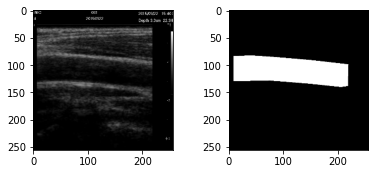

In [62]:
# Take a random photo and Test it
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)

r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

FCN-8

In [65]:
# FCN-8
project_name = "FCN-8"

channels = 3
std_shape = (256, 256, channels)
                                 
img_input = keras.layers.Input(shape = std_shape, name = "input")

conv_1 = keras.layers.Conv2D(32, kernel_size = (3, 3), activation = "relu",
                             padding = "same", name = "conv_1")(img_input)
max_pool_1 = keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2),
                                    name = "max_pool_1")(conv_1)

conv_2 = keras.layers.Conv2D(64, kernel_size = (3, 3), activation = "relu",
                             padding = "same", name = "conv_2")(max_pool_1)
max_pool_2 = keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2),
                                    name = "max_pool_2")(conv_2)

conv_3 = keras.layers.Conv2D(128, kernel_size = (3, 3), activation = "relu",
                             padding = "same", name = "conv_3")(max_pool_2)
max_pool_3 = keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2),
                                    name = "max_pool_3")(conv_3)

conv_4 = keras.layers.Conv2D(256, kernel_size = (3, 3), activation = "relu",
                             padding = "same", name = "conv_4")(max_pool_3)
max_pool_4 = keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2),
                                    name = "max_pool_4")(conv_4)

conv_5 = keras.layers.Conv2D(512, kernel_size = (3, 3), activation = "relu",
                             padding = "same", name = "conv_5")(max_pool_4)
max_pool_5 = keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2),
                                    name = "max_pool_5")(conv_5)

# max_pool_5 转置卷积上采样 2 倍和 max_pool_4 一样大
up6 = keras.layers.Conv2DTranspose(256, kernel_size = (3, 3),
                                   strides = (2, 2),
                                   padding = "same",
                                   kernel_initializer = "he_normal",
                                   name = "upsamping_6")(max_pool_5)
                
_16s = keras.layers.add([max_pool_4, up6])

# _16s 转置卷积上采样 2 倍和 max_pool_3 一样大
up_16s = keras.layers.Conv2DTranspose(128, kernel_size = (3, 3),
                                      strides = (2, 2),
                                      padding = "same",
                                      kernel_initializer = "he_normal",
                                      name = "Conv2DTranspose_16s")(_16s)
                                  
_8s = keras.layers.add([max_pool_3, up_16s])

# _8s 上采样 8 倍后与输入尺寸相同
up7 = keras.layers.UpSampling2D(size = (8, 8), interpolation = "bilinear",
                                name = "upsamping_7")(_8s)

# 这里 kernel 也是 3 * 3, 也可以同 FCN-32s 那样修改的
conv_7 = keras.layers.Conv2D(1, kernel_size = (3, 3), activation = "sigmoid",
                             padding = "same", name = "conv_7")(up7)

model = keras.Model(img_input, conv_7, name = project_name)

model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

model.summary()

Model: "FCN-8s"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 256, 256, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
max_pool_1 (MaxPooling2D)       (None, 128, 128, 32) 0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 128, 128, 64) 18496       max_pool_1[0][0]                 
_____________________________________________________________________________________________

In [69]:
# Model Predict and Save Image
def test_predict_save(modeltype,path):
  modeltype.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)
  result = modeltype.predict(test_gen)
  for i in range(100):
    img = result[i]*255
    img = cv.resize(img, (256, 256))
    img = cv.merge([img, img, img])
    #cv2_imshow(img)
    cv2.imwrite(path+test_ids[i]+"_ROI.bmp", img)

In [68]:
# Set Train, Validation, Test Data
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
test_gen = Test_DataGen(test_ids, test_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
test_steps = len(test_ids)//batch_size

In [76]:
test_predict_save(model,FCN8_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
36/36 [==============================] - 39s 1s/step - loss: 0.0213 - accuracy: 0.9892 - val_loss: 0.0218 - val_accuracy: 0.9894
Epoch 2/10
36/36 [==============================] - 39s 1s/step - loss: 0.0210 - accuracy: 0.9894 - val_loss: 0.0328 - val_accuracy: 0.9841
Epoch 3/10
36/36 [==============================] - 39s 1s/step - loss: 0.0213 - accuracy: 0.9892 - val_loss: 0.0285 - val_accuracy: 0.9875
Epoch 4/10
36/36 [==============================] - 39s 1s/step - loss: 0.0233 - accuracy: 0.9884 - val_loss: 0.0349 - val_accuracy: 0.9843
Epoch 5/10
36/36 [==============================] - 39s 1s/step - loss: 0.0229 - accuracy: 0.9889 - val_loss: 0.0273 - val_accuracy: 0.9862
Epoch 6/10
36/36 [==============================] - 39s 1s/step - loss: 0.0203 - accuracy: 0.9895 - val_loss: 0.0260 - val_accuracy: 0.9879
Epoch 7/10
36/36 [==============================] - 39s 1s/step - loss: 0.0193 - accuracy: 0.9898 - val_loss: 0.0194 - val_accuracy: 0.9901
Epoch 8/10
36/36 [==

FCN-16

In [78]:
# FCN-16
project_name = "FCN-16"

channels = 3
std_shape = (256, 256, channels) 

img_input = keras.layers.Input(shape = std_shape, name = "input")

conv_1 = keras.layers.Conv2D(32, kernel_size = (3, 3), activation = "relu",
                             padding = "same", name = "conv_1")(img_input)
max_pool_1 = keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2),
                                    name = "max_pool_1")(conv_1)

conv_2 = keras.layers.Conv2D(64, kernel_size = (3, 3), activation = "relu",
                             padding = "same", name = "conv_2")(max_pool_1)
max_pool_2 = keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2),
                                    name = "max_pool_2")(conv_2)

conv_3 = keras.layers.Conv2D(128, kernel_size = (3, 3), activation = "relu",
                             padding = "same", name = "conv_3")(max_pool_2)
max_pool_3 = keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2),
                                    name = "max_pool_3")(conv_3)

conv_4 = keras.layers.Conv2D(256, kernel_size = (3, 3), activation = "relu",
                             padding = "same", name = "conv_4")(max_pool_3)
max_pool_4 = keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2),
                                    name = "max_pool_4")(conv_4)

conv_5 = keras.layers.Conv2D(512, kernel_size = (3, 3), activation = "relu",
                             padding = "same", name = "conv_5")(max_pool_4)
max_pool_5 = keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2),
                                    name = "max_pool_5")(conv_5)

# max_pool_5 转置卷积上采样 2 倍至 max_pool_4 一样大
up6 = keras.layers.Conv2DTranspose(256, kernel_size = (3, 3),
                                   strides = (2, 2),
                                   padding = "same",
                                   kernel_initializer = "he_normal",
                                   name = "upsamping_6")(max_pool_5)
                
_16s = keras.layers.add([max_pool_4, up6])

# _16s 上采样 16 倍后与输入尺寸相同
up7 = keras.layers.UpSampling2D(size = (16, 16), interpolation = "bilinear",
                                name = "upsamping_7")(_16s)

# 这里 kernel 也是 3 * 3, 也可以同 FCN-32s 那样修改的
conv_7 = keras.layers.Conv2D(1, kernel_size = (3, 3), activation = "sigmoid",
                             padding = "same", name = "conv_7")(up7)

model = keras.Model(img_input, conv_7, name = project_name)

model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

model.summary()

Model: "FCN-16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 256, 256, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
max_pool_1 (MaxPooling2D)       (None, 128, 128, 32) 0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 128, 128, 64) 18496       max_pool_1[0][0]                 
_____________________________________________________________________________________________

In [79]:
test_predict_save(model,FCN16_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
36/36 [==============================] - 66s 2s/step - loss: 0.3579 - accuracy: 0.8573 - val_loss: 0.2932 - val_accuracy: 0.8524
Epoch 2/10
36/36 [==============================] - 64s 2s/step - loss: 0.2000 - accuracy: 0.9161 - val_loss: 0.1131 - val_accuracy: 0.9635
Epoch 3/10
36/36 [==============================] - 64s 2s/step - loss: 0.1005 - accuracy: 0.9579 - val_loss: 0.0753 - val_accuracy: 0.9652
Epoch 4/10
36/36 [==============================] - 64s 2s/step - loss: 0.0622 - accuracy: 0.9727 - val_loss: 0.0741 - val_accuracy: 0.9708
Epoch 5/10
36/36 [==============================] - 64s 2s/step - loss: 0.0459 - accuracy: 0.9797 - val_loss: 0.0515 - val_accuracy: 0.9782
Epoch 6/10
36/36 [==============================] - 64s 2s/step - loss: 0.0341 - accuracy: 0.9839 - val_loss: 0.0354 - val_accuracy: 0.9835
Epoch 7/10
36/36 [==============================] - 64s 2s/step - loss: 0.0362 - accuracy: 0.9836 - val_loss: 0.0566 - val_accuracy: 0.9763
Epoch 8/10
36/36 [==

FCN-32

In [85]:
# FCN-32
project_name = "FCN-32"

channels = 3
std_shape = (256, 256, channels) 

model = keras.Sequential(name = project_name)

model.add(keras.layers.Conv2D(32, kernel_size = (3, 3), activation = "relu",
                              padding = "same", input_shape = std_shape,
                              name = "conv_1"))
model.add(keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2), name = "max_pool_1"))

model.add(keras.layers.Conv2D(64, kernel_size = (3, 3), activation = "relu",
                              padding = "same", name = "conv_2"))
model.add(keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2), name = "max_pool_2"))

model.add(keras.layers.Conv2D(128, kernel_size = (3, 3), activation = "relu",
                              padding = "same", name = "conv_3"))
model.add(keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2), name = "max_pool_3"))

model.add(keras.layers.Conv2D(256, kernel_size = (3, 3), activation = "relu",
                              padding = "same", name = "conv_4"))
model.add(keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2), name = "max_pool_4"))

model.add(keras.layers.Conv2D(512, kernel_size = (3, 3), activation = "relu",
                              padding = "same", name = "conv_5"))
model.add(keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2), name = "max_pool_5"))

model.add(keras.layers.UpSampling2D(size = (32, 32), interpolation = "nearest", name = "upsamping_6"))



# 这里只有一个卷积核, 可以把 kernel_size 改成 1 * 1, 也可以是其他的, 只是要注意 padding 的尺寸
# 也可以放到 upsamping_6 的前面, 试着改一下尺寸和顺序看一下效果
# 这里只是说明问题, 尺寸和顺序不一定是最好的
model.add(keras.layers.Conv2D(1, kernel_size = (3, 3), activation = "sigmoid", padding = "same", name = "conv_7"))

model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

model.summary()

Model: "FCN-32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pool_3 (MaxPooling2D)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 32, 32, 256)       29516

In [86]:
test_predict_save(model,FCN32_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
36/36 [==============================] - 128s 4s/step - loss: 0.3816 - accuracy: 0.8431 - val_loss: 0.3409 - val_accuracy: 0.8524
Epoch 2/10
36/36 [==============================] - 113s 3s/step - loss: 0.3174 - accuracy: 0.8599 - val_loss: 0.3118 - val_accuracy: 0.8524
Epoch 3/10
36/36 [==============================] - 113s 3s/step - loss: 0.2717 - accuracy: 0.8690 - val_loss: 0.2689 - val_accuracy: 0.8837
Epoch 4/10
36/36 [==============================] - 115s 3s/step - loss: 0.2092 - accuracy: 0.9098 - val_loss: 0.2341 - val_accuracy: 0.8928
Epoch 5/10
36/36 [==============================] - 113s 3s/step - loss: 0.1724 - accuracy: 0.9279 - val_loss: 0.1875 - val_accuracy: 0.9259
Epoch 6/10
36/36 [==============================] - 114s 3s/step - loss: 0.1492 - accuracy: 0.9346 - val_loss: 0.1819 - val_accuracy: 0.9155
Epoch 7/10
36/36 [==============================] - 113s 3s/step - loss: 0.1342 - accuracy: 0.9409 - val_loss: 0.1983 - val_accuracy: 0.9167
Epoch 8/10
36